In [ ]:
!nvidia-smi

Sun Dec 26 14:23:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# importing dependcies 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
import sys
import shutil  
from torch.utils import data
import random
from os.path import exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#linking to the driver
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Getting the api josn file to download the data from kaggle (competition authorization) 
# from google.colab import files
# files.upload()

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission

In [ ]:
# Downloading data to the drive 
# !kaggle competitions download -c state-farm-distracted-driver-detection -p /content/gdrive/My\ Drive/kaggle/State-Farm-Distracted-Driver-Detection

In [ ]:
# #unzipping the data to co files
# !unzip -qq /content/gdrive/MyDrive/kaggle/State-Farm-Distracted-Driver-Detection/imgs.zip
# !unzip -qq /content/gdrive/MyDrive/kaggle/State-Farm-Distracted-Driver-Detection/driver_imgs_list.csv.zip
# !unzip -qq /content/gdrive/MyDrive/kaggle/State-Farm-Distracted-Driver-Detection/sample_submission.csv.zip

In [ ]:
!unzip -qq '/content/gdrive/MyDrive/MI Project/DDS_fullData/train.zip'
!unzip -qq '/content/gdrive/MyDrive/MI Project/DDS_fullData/v.zip'
!unzip -qq '/content/gdrive/MyDrive/MI Project/DDS_fullData/test.zip'
!mv /content/content/t /content/train
!mv /content/content/v /content/valid

In [ ]:
# data exploration
for i in range(10):
  print(f'number of smaples in class {i} is {len(os.listdir("/content/train/c"+str(i)))}')

number of smaples in class 0 is 2683
number of smaples in class 1 is 2458
number of smaples in class 2 is 2511
number of smaples in class 3 is 2546
number of smaples in class 4 is 2513
number of smaples in class 5 is 2508
number of smaples in class 6 is 2521
number of smaples in class 7 is 2229
number of smaples in class 8 is 2171
number of smaples in class 9 is 2386


In [ ]:
# directory = '/content/valid'
# if not os.path.exists(directory): 
#     os.makedirs(directory)

# for i in range(0,10):
#   c= 'c'+ str(i) 
#   directory = f'/content/valid/{c}'
#   if not os.path.exists(directory):
#     os.makedirs(directory)

In [ ]:
# data exploration
for i in range(10):
  print(f'number of smaples in class {i} is {len(os.listdir("/content/valid/c"+str(i)))}')

number of smaples in class 0 is 406
number of smaples in class 1 is 409
number of smaples in class 2 is 406
number of smaples in class 3 is 400
number of smaples in class 4 is 413
number of smaples in class 5 is 404
number of smaples in class 6 is 404
number of smaples in class 7 is 373
number of smaples in class 8 is 340
number of smaples in class 9 is 343


In [ ]:
# setting the folder structure
data_dir = '/content'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# # Labels mapping (for example: safe-driving -> C0, Texting-> C6, ...)
# import json
# # make sure that the cat.json file not missing 
# with open('/content/gdrive/MyDrive/cate.json', 'r') as f:
#     cat_to_name = json.load(f)

cat_to_name ={"c0":"safe driving",
              "c1":"texting - right",
              "c2":"talking on the phone - right",
              "c3":"texting - left",
              "c4":"talking on the phone - left",
              "c5":"operating the radio",
              "c6":"drinking",
              "c7":"reaching behind",
              "c8":"hair and makeup",
              "c9":"talking to passenger"}

In [ ]:
# Data preview 
def view_image(img, mapper):
    ''' Function for viewing an image and its classes before augmentation.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, ax1 = plt.subplots(figsize=(7,11)) 
    driver_type = mapper[img_filename]
        
    ax1.set_title(driver_type)
    ax1.imshow(img)
    ax1.axis('off')

for i in range(0,10):
  c = 'c' + str(i)
  path = f'/content/train/{c}'
  dirs = os.listdir( path )
  img = f'/content/train/{c}/{dirs[0]}'
  view_image(img,cat_to_name)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# preparing the data for the data generators and doing a little data augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names= image_datasets['train'].classes

NameError: ignored

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# display the effect of Augmentation

data_Aug = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train'),data_transforms['train']), 
                                       batch_size=32, shuffle=True, num_workers=2)

data_noAug = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['valid']), 
                                         batch_size=32, shuffle=True, num_workers=2)

# # With Aug
# inputs, classes = next(iter(data_Aug))
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)
# plt.figure(figsize=(20, 20))
# imshow(out, title='With Augmetation')

# # withought Aug
# inputs, classes = next(iter(data_noAug))
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)
# plt.figure(figsize=(20, 20))
# imshow(out, title='Without Augmetation')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# building and training the classifier 

# Load resnet-50 pre-trained network

#TODO: use ResNet50v2:: wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
model = models.wide_resnet50_2(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
# setting the expeirments 
number_to_freeze = 68 #  number of layers to freeze
for i, param in enumerate(model.parameters()):
    if(i >= number_to_freeze): break
    param.requires_grad = False

from collections import OrderedDict

class ReShape_(torch.nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, 8, 256)

class extractlastcell(nn.Module):
  def forward(self,x):
    out , _ = x
    return out[:, -1, :]

# creating the classifier ordered dictionary first
classifier = nn.Sequential(OrderedDict([
                                        #TODO: add spatialdropout>> Dropout2d, GlobalAveragePooling2D befor fc1
                          # ('drop2d', nn.Dropout2d(p=0.4)),
                          # ('fc1', nn.Linear(2048, 256)), #TODO: add => nn.RNN(2048, 256, bidirectional=True) 
                          ('reshape', ReShape_()),
                          ('LSTM', nn.LSTM(256, 128, bidirectional=True)),
                          ('lastCell', extractlastcell()),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(256, 10)),
                          ('output', nn.Softmax(dim=1))
                          ]))

# replacing the pretrained model classifier with our classifier
model.fc = classifier

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
from tqdm.notebook import trange, tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()

  best_acc = 0.0

  for epoch in trange(1, num_epochs+1):
      print('Epoch {}/{}'.format(epoch, num_epochs))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'valid']:
          if phase == 'train':
              scheduler.step()
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in tqdm(dataloaders[phase]):
              inputs, labels = inputs.to(device), labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'valid' and epoch_acc > best_acc:
              best_acc = epoch_acc
              
              # best accuracy wt checkpoint
              model.class_to_idx = dataloaders['train'].dataset.class_to_idx
              model.epochs = epoch
              checkpoint = {'input_size': [3, 244, 244],
                            'batch_size': dataloaders['train'].batch_size,
                            'output_size': 10,
                            'state_dict': model.state_dict(),
                            'data_transforms': data_transforms,
                            'optimizer_dict':optimizer.state_dict(),
                            'class_to_idx': model.class_to_idx,
                            'epoch': model.epochs}
              torch.save(checkpoint, '/content/gdrive/MyDrive/Naser_DDS/test2_LSTM_wideResNet50v2_20Epochs_pytorch.pth')           
      
      #last epoch wt checkpoint
      model.class_to_idx = dataloaders['train'].dataset.class_to_idx
      model.epochs = epoch
      checkpoint = {'input_size': [3, 244, 244],
                    'batch_size': dataloaders['train'].batch_size,
                    'output_size':10,
                    'state_dict': model.state_dict(),
                    'data_transforms': data_transforms,
                    'optimizer_dict':optimizer.state_dict(),
                    'class_to_idx': model.class_to_idx,
                    'epoch': model.epochs}
      torch.save(checkpoint, '/content/gdrive/MyDrive/Naser_DDS/test2_LSTM_wideResNet50v2_20Epochs_pytorch_last.pth')
      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best valid accuracy: {:4f}'.format(best_acc))

  # load best model weights
  checkpoint = torch.load('/content/gdrive/MyDrive/Naser_DDS/test2_LSTM_wideResNet50v2_20Epochs_pytorch.pth')
  model.load_state_dict(checkpoint['state_dict'])
  return model

In [ ]:
# Train the model
num_epochs = 10 # todo : train the best model for 100 epochs
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
####TODO: add label_smoothing = 0.2
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=.001) #removed model.fc
# Optimizer = optim.SGD(model.fc.parameters(), lr = .1, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.55)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Using GPU: True


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.8094 Acc: 0.7984


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7644 Acc: 0.8504

Epoch 2/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.7225 Acc: 0.9033


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7639 Acc: 0.8479

Epoch 3/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.6892 Acc: 0.9422


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7757 Acc: 0.8307

Epoch 4/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.6834 Acc: 0.9494


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7388 Acc: 0.8807

Epoch 5/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.6665 Acc: 0.9688


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7083 Acc: 0.9166

Epoch 6/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.6617 Acc: 0.9749


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7141 Acc: 0.9082

Epoch 7/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.6604 Acc: 0.9764


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7288 Acc: 0.8892

Epoch 8/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.6589 Acc: 0.9784


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7276 Acc: 0.8912

Epoch 9/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

train Loss: 1.6560 Acc: 0.9819


  0%|          | 0/122 [00:00<?, ?it/s]

valid Loss: 1.7168 Acc: 0.9061

Epoch 10/10
----------


  0%|          | 0/767 [00:00<?, ?it/s]

In [ ]:
# after training we load the best saved check point

def load_checkpoint(filepath):
    """ a function that loads a checkpoint and rebuilds the model """
    checkpoint = torch.load(filepath)
    model = models.wide_resnet50_2(pretrained=True)
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 10
    
    classifier = nn.Sequential(OrderedDict([
                              #TODO: add spatialdropout>> Dropout2d, GlobalAveragePooling2D befor fc1
                              # ('drop2d', nn.Dropout2d(p=0.4)),
                              # ('fc1', nn.Linear(2048, 256)), #TODO: add => nn.RNN(2048, 256, bidirectional=True) 
                              ('reshape', ReShape_()),
                              ('LSTM', nn.LSTM(256, 128, bidirectional=True)),
                              ('lastCell', extractlastcell()),
                              ('relu', nn.ReLU()),
                              ('dropout1', nn.Dropout(p=0.5)),
                              ('fc2', nn.Linear(256, 10)),
                              ('output', nn.Softmax(dim=1))
                              ]))


    # replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/content/gdrive/MyDrive/MI Project/test2_LSTM_wideResNet50v2_20Epochs_pytorch.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [ ]:
# testing the model

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 361, 361
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

def predict(image_path, model,  topk ,transform):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    image = transform(Image.open(image_path)).unsqueeze(0)
    model.eval()
    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_idx , top_probability, top_class

top_classes_idx , top_probabilites , top_classes  = predict('/content/valid/c3/img_100139.jpg', loaded_model , 3 , data_transforms['valid'])
print(top_classes_idx[0])

3


In [ ]:
# Display an image along with the top 3 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(7,11), ncols=1, nrows=2) 
    driver_type = mapper[img_filename]
    
    ax1.set_title(driver_type)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

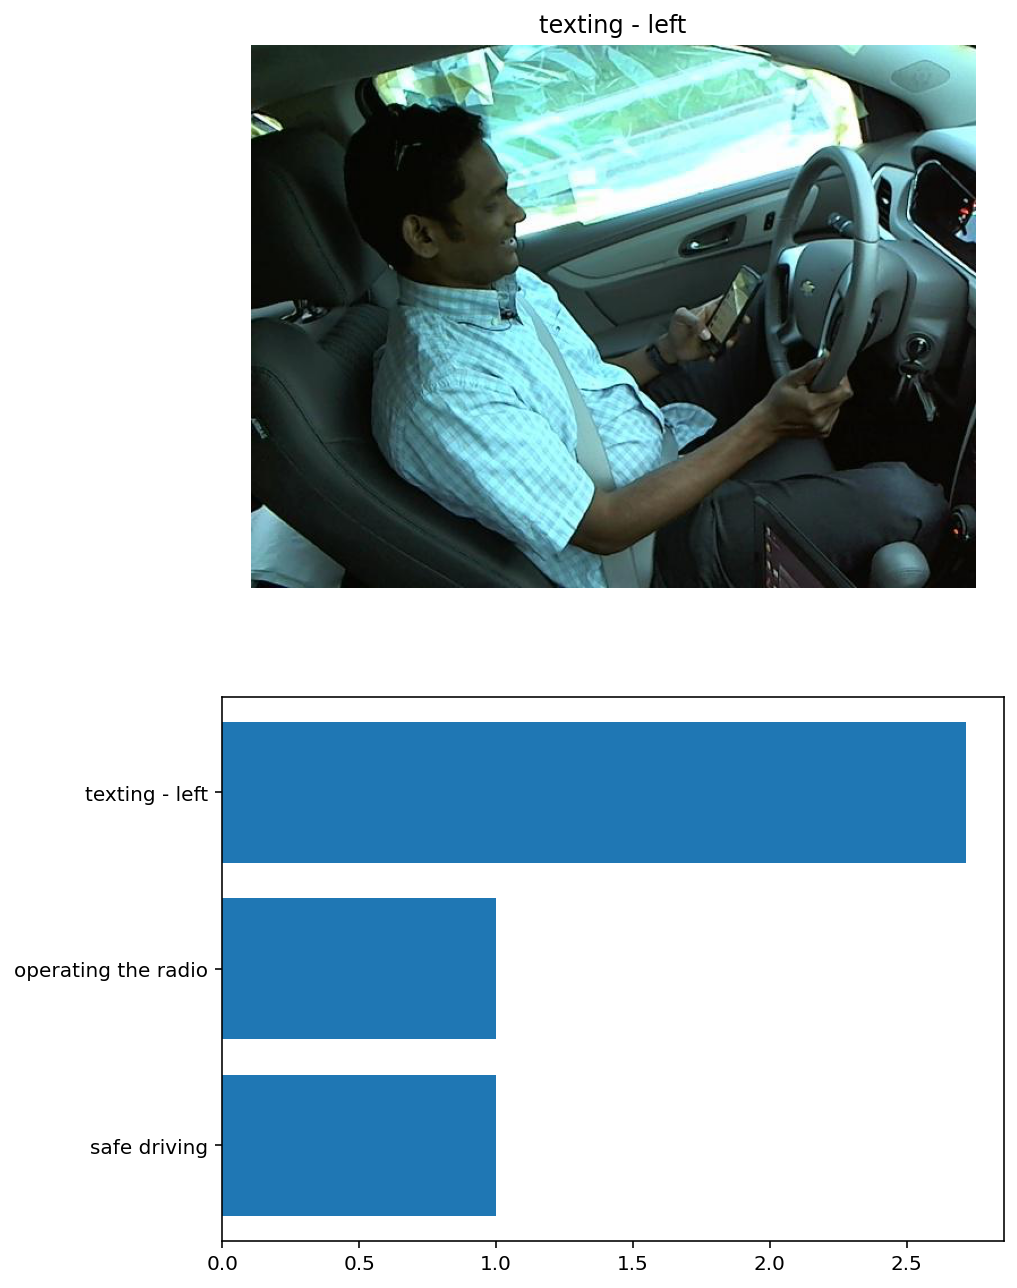

In [ ]:
img ='/content/valid/c3/img_100139.jpg'
_ , p, c = predict(img, loaded_model , 3 , data_transforms['valid'])
view_classify(img, p, c, cat_to_name)

In [ ]:
# evaluation 

# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
     
  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))


test(loaded_model, dataloaders, device)

Testing Accuracy: 0.917


In [ ]:
y_pred = []
y_true = []

loaded_model.eval()
accuracy = 0

loaded_model.to(device)
  
for images, labels in dataloaders['valid']:
  images = Variable(images)
  labels = Variable(labels)
  images, labels = images.to(device), labels.to(device)
    
  output = loaded_model.forward(images)
  ps = torch.exp(output)
  pred = ps.max(1)[1]
  y_pred.extend(pred.cpu().numpy())
  y_true.extend(labels.cpu().numpy())

from sklearn.metrics import recall_score , f1_score ,precision_score
print(' recall is : ' , recall_score (y_true, y_pred, average='macro'))
print(' precision is : ' , precision_score(y_true, y_pred, average='macro'))
print(' f1 Score is : ' , f1_score(y_true, y_pred, average='macro'))


 recall is :  0.910520619835653
 precision is :  0.925778046209004
 f1 Score is :  0.9136150521130204


In [ ]:
nb_classes = 10 
confusion_matrix = torch.zeros(nb_classes , nb_classes)
with torch.no_grad():
  for i , (inputs,classes) in enumerate(dataloaders['valid']):
    inputs = inputs.to(device) 
    classes = classes.to(device) 
    loaded_model.to(device)
    outputs = loaded_model(inputs)
    _ , preds = torch.max(outputs , 1 )
    for t,p in zip(classes.view(-1) , preds.view(-1)):
      confusion_matrix[t.long() , p.long()] +=1

print(confusion_matrix) 

tensor([[379.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,  21.],
        [  1., 405.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.],
        [  0.,   1., 401.,   0.,   0.,   0.,   1.,   0.,   3.,   0.],
        [ 23.,   0.,   0., 372.,   5.,   0.,   0.,   0.,   0.,   0.],
        [ 13.,   0.,   1.,   4., 387.,   0.,   2.,   0.,   6.,   0.],
        [  5.,   0.,   0.,   0.,   0., 399.,   0.,   0.,   0.,   0.],
        [  0.,  10.,   1.,   0.,   0.,   0., 391.,   0.,   2.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1., 349.,  18.,   5.],
        [ 36.,   0.,   3.,   0.,   3.,   0.,   0.,  26., 270.,   2.],
        [115.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,   2., 223.]])


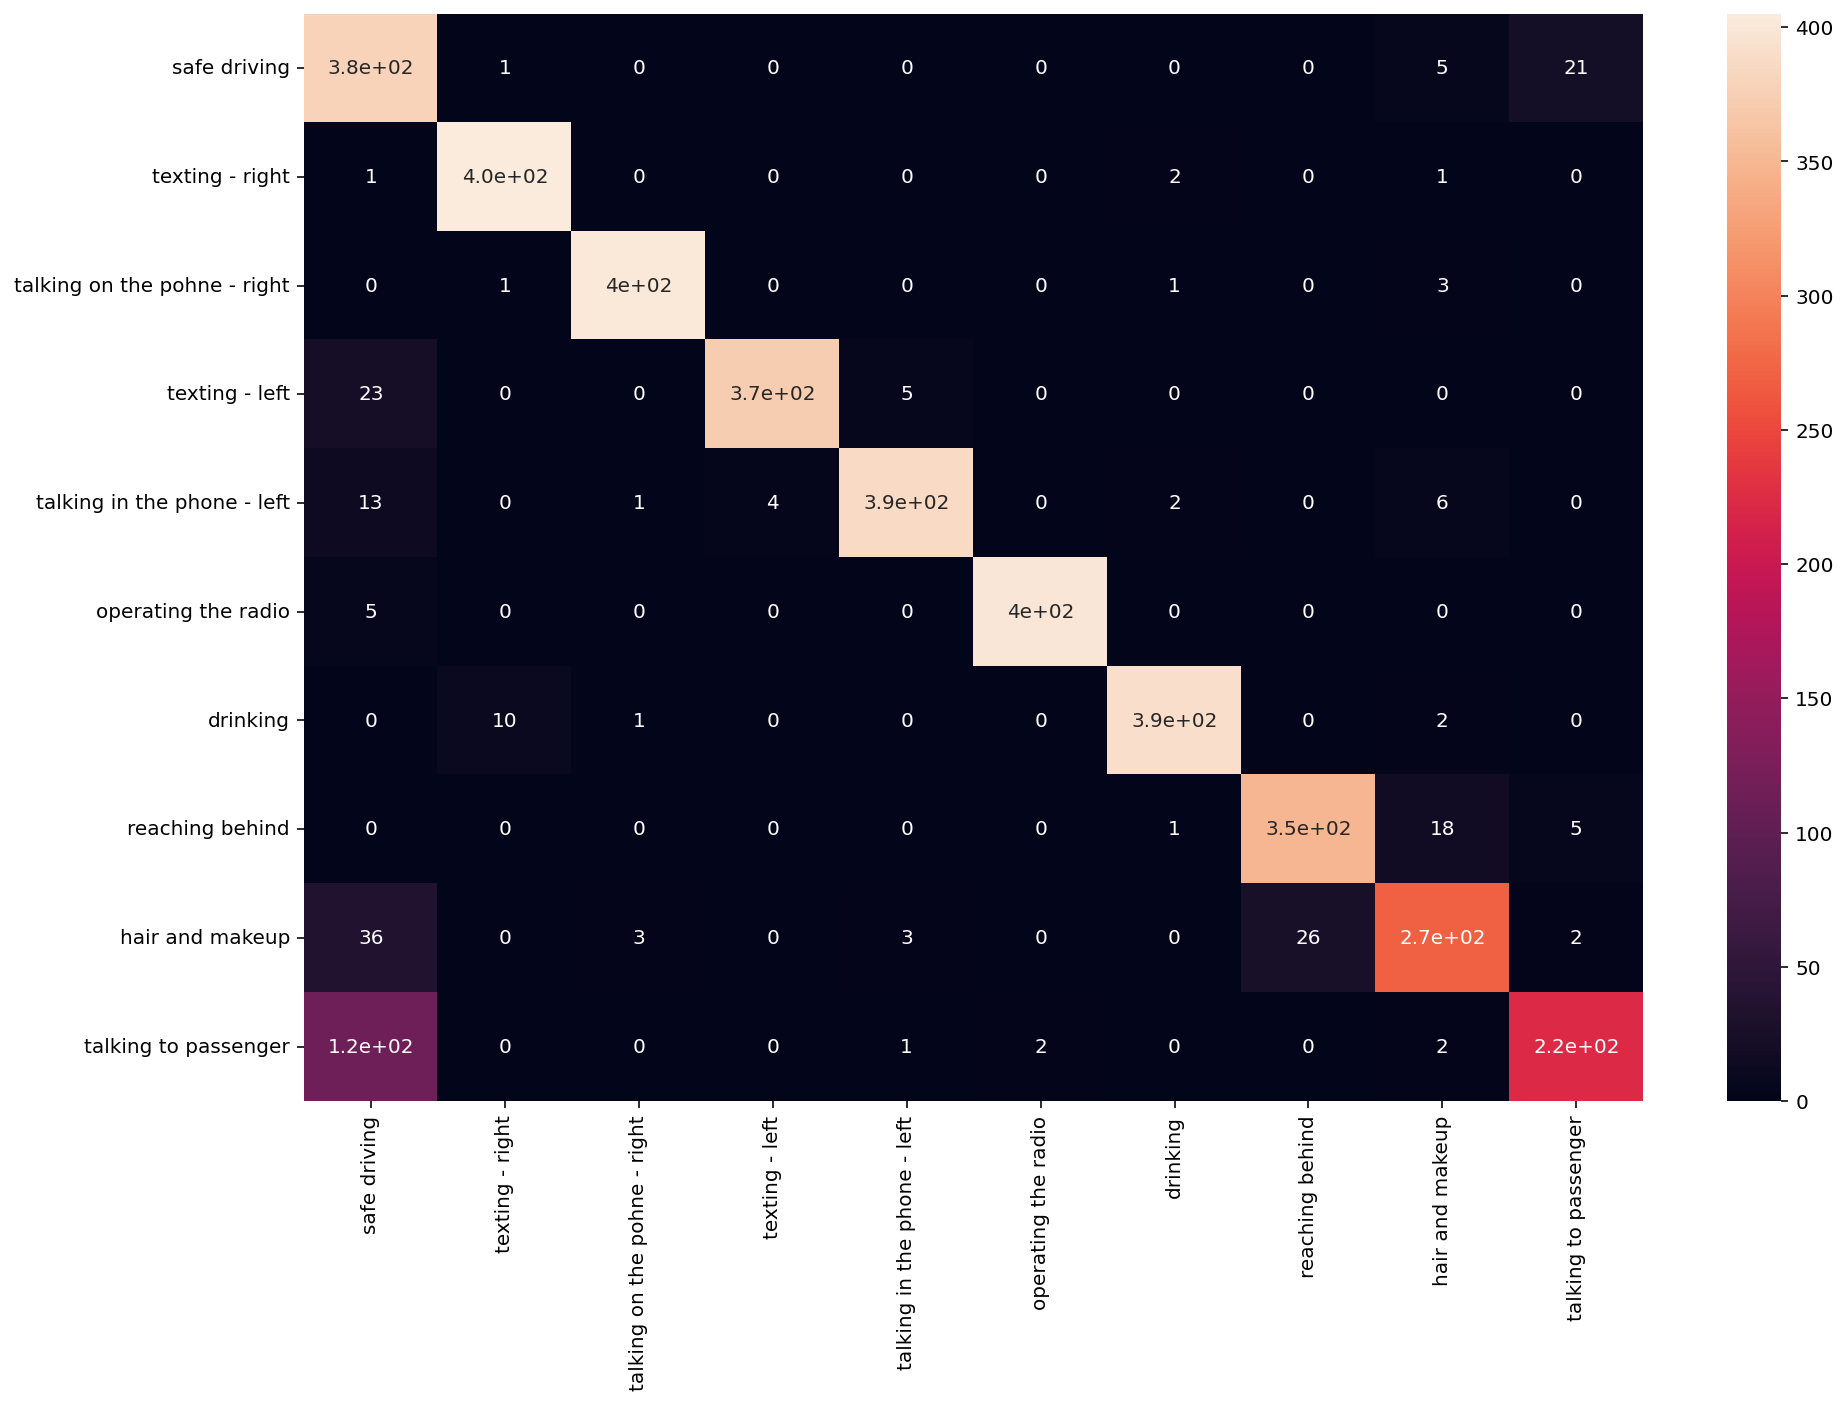

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix.cpu().numpy() 
df_cm = pd.DataFrame(array, index =  ['safe driving' , 'texting - right' , 'talking on the pohne - right' , 'texting - left' , 'talking in the phone - left' , 'operating the radio' , 'drinking' , 'reaching behind' ,'hair and makeup' ,'talking to passenger'],
                  columns = ['safe driving' , 'texting - right' , 'talking on the pohne - right' , 'texting - left' , 'talking in the phone - left' , 'operating the radio' , 'drinking' , 'reaching behind' ,'hair and makeup' ,'talking to passenger'])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)